In [44]:
import numpy as np
from matplotlib import pyplot as plt, rcParams
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.linear_model import LinearRegression, Lasso
from scipy.stats import wasserstein_distance
import json

rcParams["figure.figsize"] = (8, 5)
rcParams["figure.dpi"] = 100
set_matplotlib_formats("retina")
plt.style.use("seaborn")

In [51]:
output = np.load("output/output.npz")

X_vals = output["activations"]
y = output["targets"]

# Correlation

In [45]:
def do_corr(lnum, activations, targets):
    corrs = []
    for ind in range(activations.shape[2]):
        result = np.corrcoef(targets[:, 0], activations[:, lnum, ind])
        corrs.append(result[0, 1])
    return corrs

In [52]:
X_vals.shape

(6920, 49, 1600)

In [53]:
corr = do_corr(48, X_vals, y)
rand_corr = do_corr(48, X_vals, np.random.uniform(0,2,y.shape))

# corr.sort()
# rand_corr.sort()

In [54]:
48 * 1600 + np.array(corr).argmin()

78206

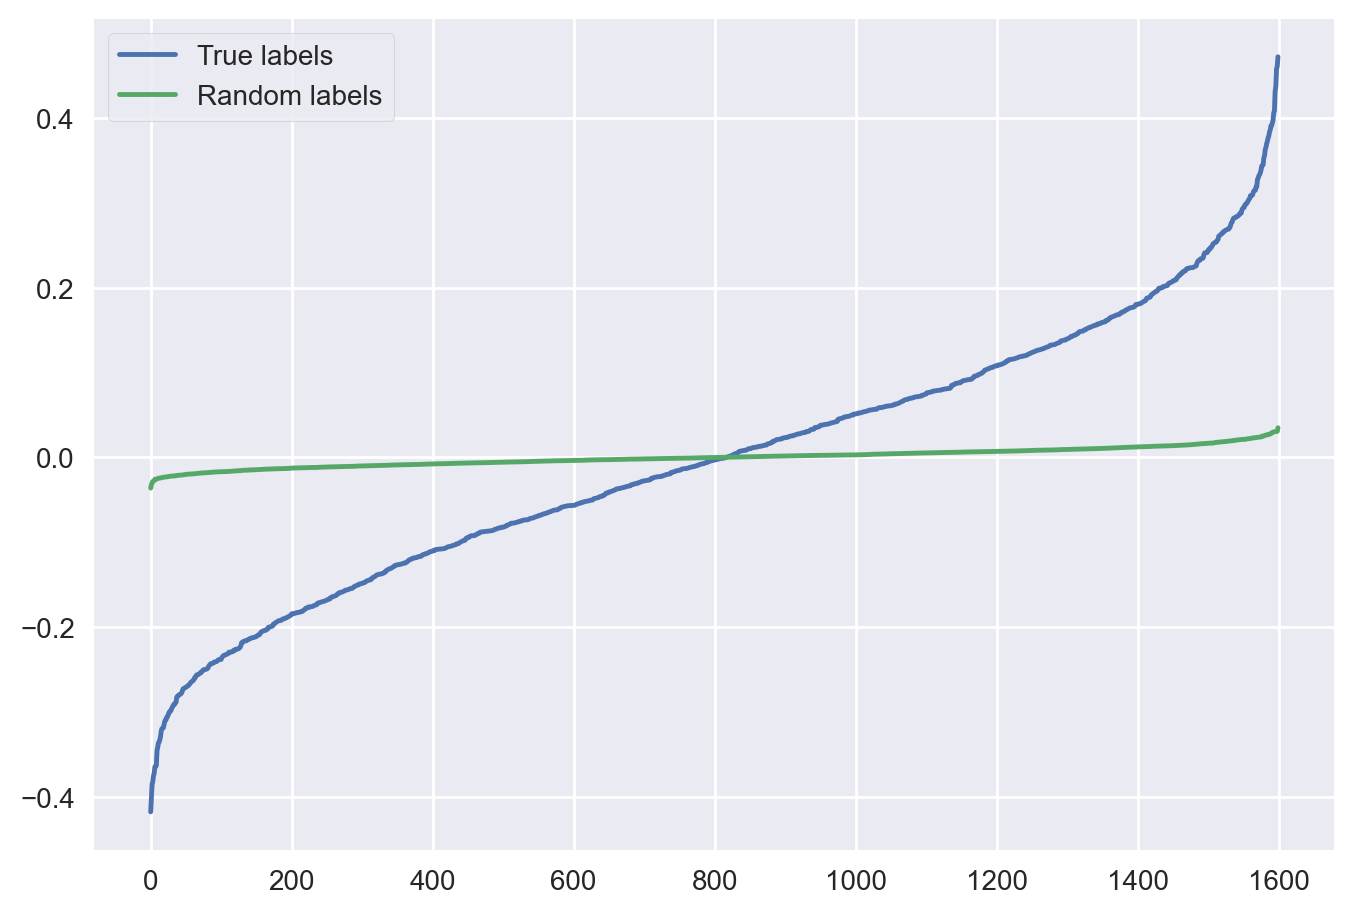

In [55]:
plt.plot(sorted(corr), label="True labels")
plt.plot(sorted(rand_corr), label="Random labels")
plt.legend(frameon=True)
plt.show()

In [56]:
corrs = []
rand_corrs = []
for l_num in range(49):
    corr = do_corr(l_num, X_vals, y)
    rand_corr = do_corr(l_num, X_vals, np.random.uniform(0,2,y.shape))

    corr.sort()
    rand_corr.sort()

    corrs.append(corr)
    rand_corrs.append(rand_corr)

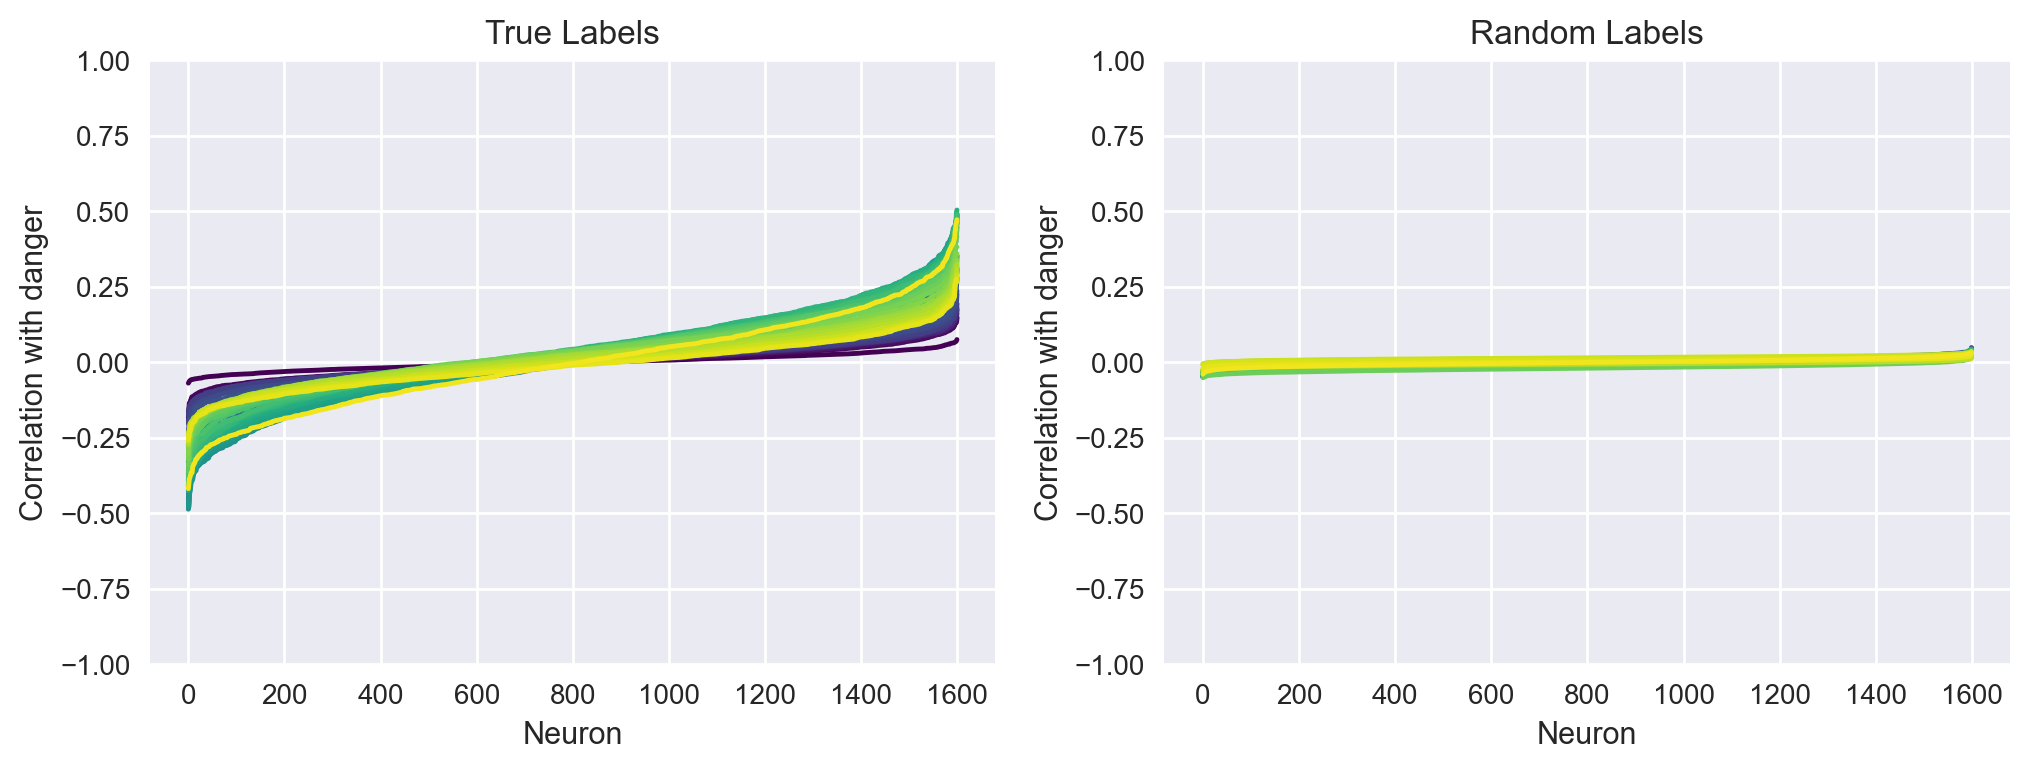

In [58]:
plt.figure(figsize=(12,4))

plt.subplot(121)
for l_num in range(49):
    c = corrs[l_num]
    plt.plot(c, color=plt.cm.viridis(l_num / 49))
plt.title('True Labels')
plt.xlabel("Neuron")
plt.ylabel("Correlation with danger")
plt.ylim([-1, 1])

plt.subplot(122)
for l_num in range(49):
    c = rand_corrs[l_num]
    plt.plot(c, color=plt.cm.viridis(l_num / 49))
plt.title('Random Labels')
plt.xlabel("Neuron")
plt.ylabel("Correlation with danger")
plt.ylim([-1, 1])

plt.show()

In [67]:
N_NEURONS = 100
MODEL_SHAPE = (49, 1600)
corray = np.array(corrs).ravel()

neurons_per_layer = {}
for corr_index in corray.argsort()[::-1][:N_NEURONS]:
    layer, neuron = np.unravel_index(corr_index, MODEL_SHAPE)
    layer, neuron = int(layer), int(neuron)
    if layer in neurons_per_layer:
        neurons_per_layer[layer].append(neuron)
    else:
        neurons_per_layer[layer] = [neuron]


In [ ]:
with open('neurons_per_layer.json', 'w') as file:
    json.dump(neurons_per_layer, file)

# Regression

In [117]:
alpha_vals = [1, 5e-1, 2e-1, 1e-1, 5e-2, 2e-2, 1e-2]
r2_scores = []
coefs = []
n_coefs = []

for alpha in alpha_vals:
    model = Lasso(alpha=alpha)
    model.fit(X_vals[:, 48], y.squeeze())
    coefs.append(model.coef_)
    n_coefs.append(model.coef_[model.coef_ != 0].size)
    r2_scores.append(model.score(X_vals[:, 48], y.squeeze()))
    

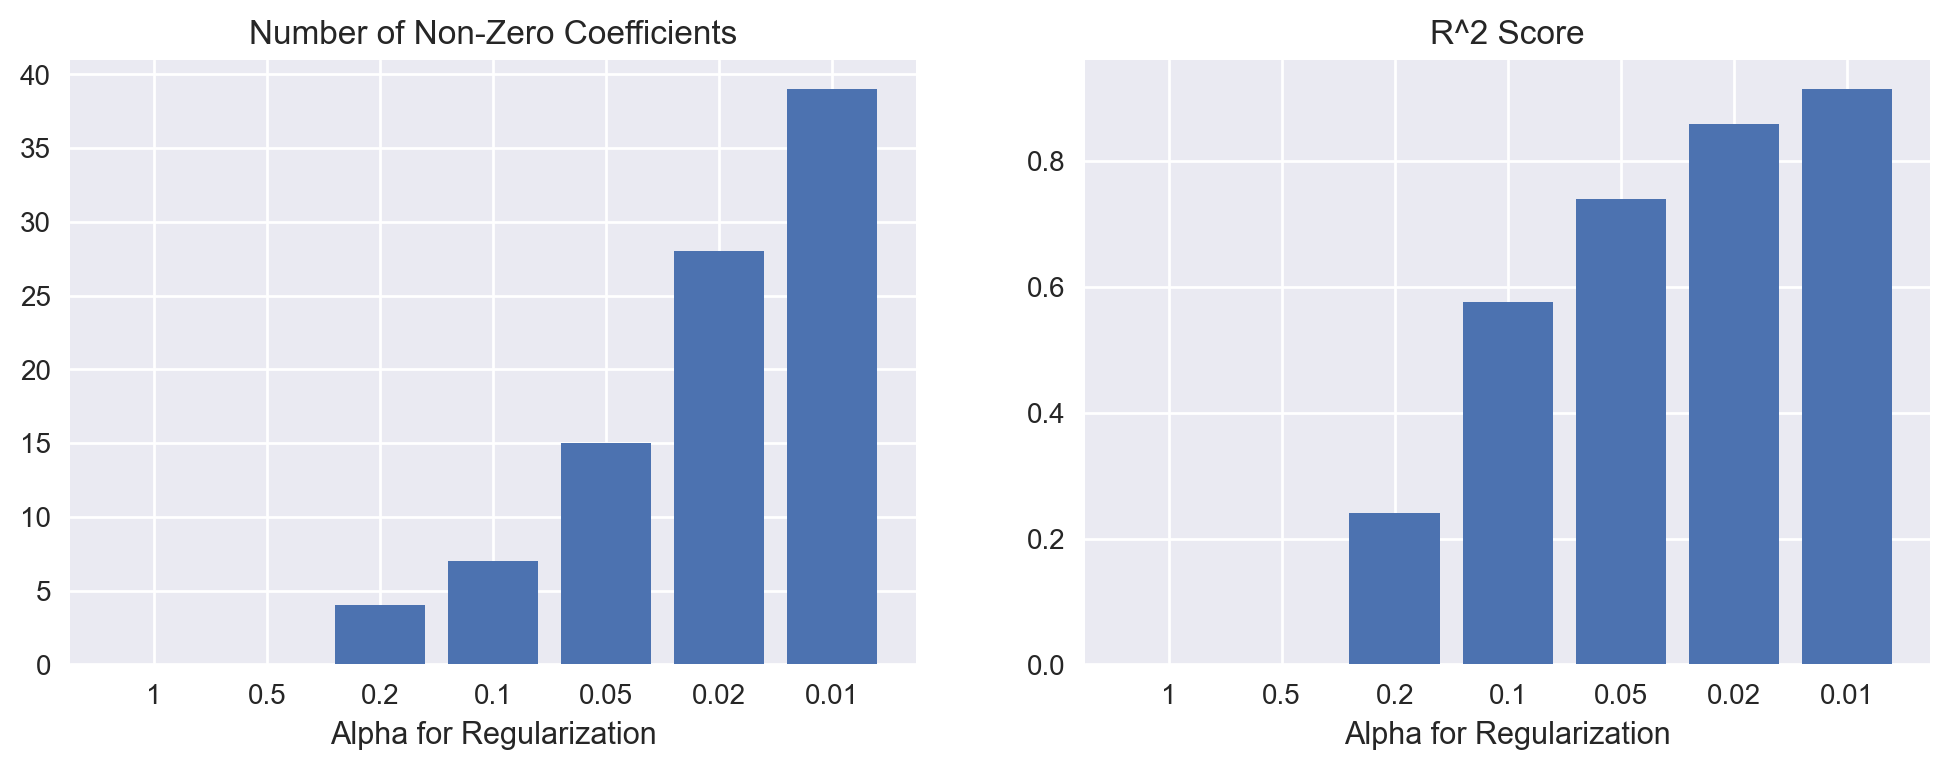

In [118]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.bar(x=list(map(str, alpha_vals)), height=n_coefs)
plt.title('Number of Non-Zero Coefficients')
plt.xlabel('Alpha for Regularization')

plt.subplot(122)
plt.bar(x=list(map(str, alpha_vals)), height=r2_scores)
plt.title('R^2 Score')
plt.xlabel('Alpha for Regularization')

plt.show()

In [119]:
layer_coefs = []
layer_r2_scores = []

for i in range(49):
    model = Lasso(alpha=0.5, max_iter=10000)
    model.fit(X_vals[:, i], y.squeeze())
    layer_coefs.append(model.coef_[model.coef_ != 0].size)
    layer_r2_scores.append(model.score(X_vals[:, i], y.squeeze()))

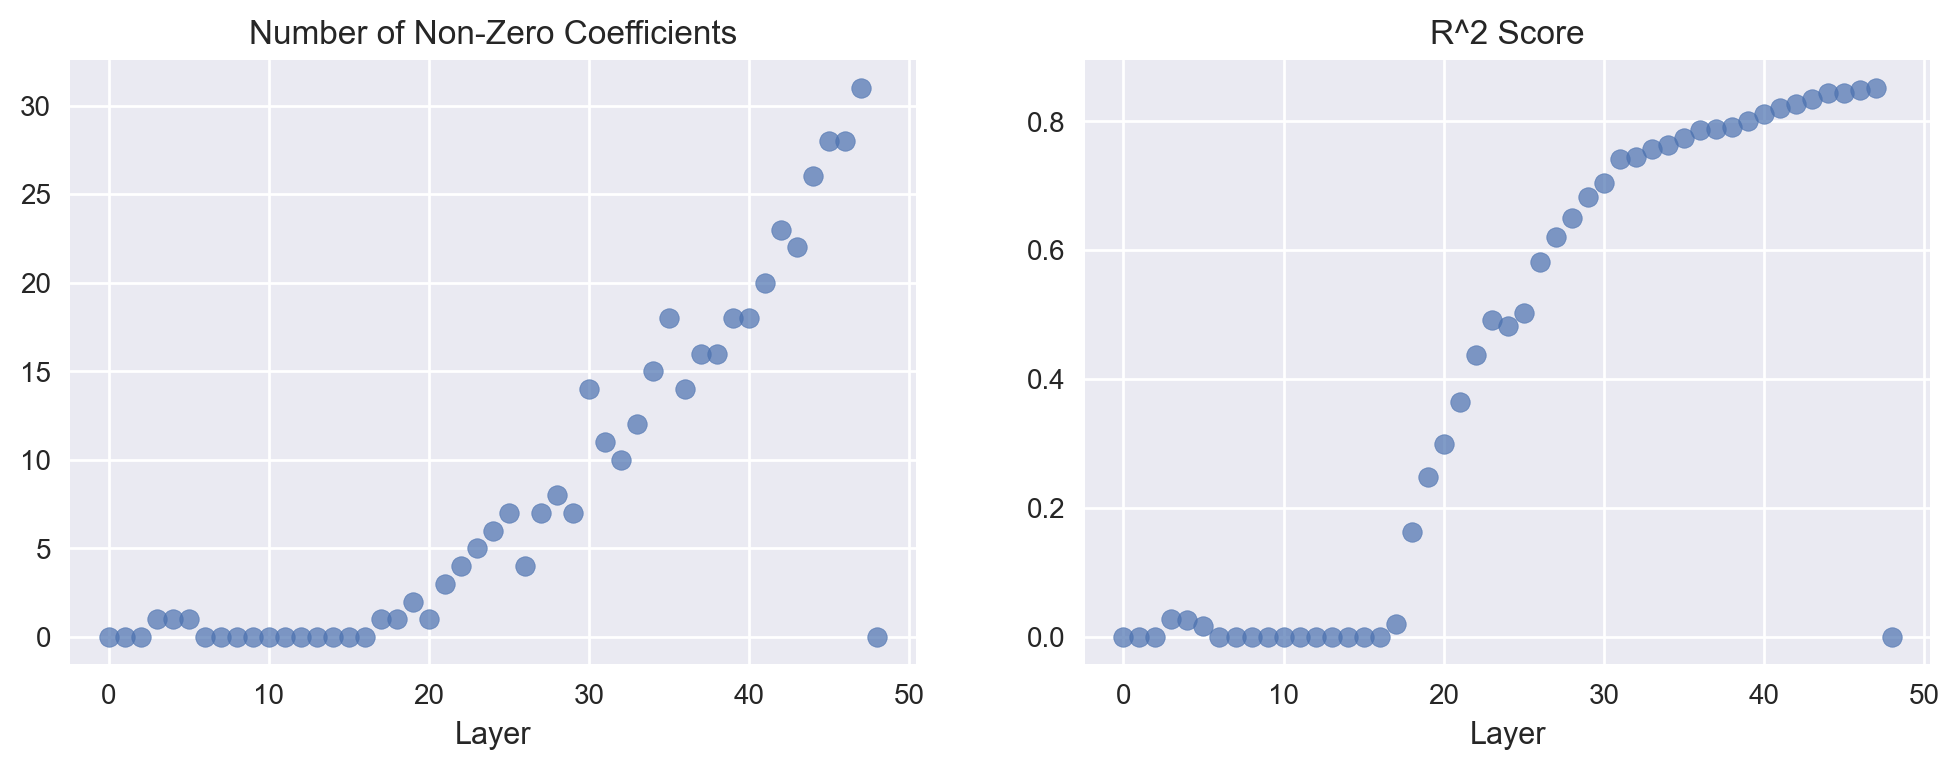

In [120]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.scatter(np.arange(49), layer_coefs, alpha=0.7)
plt.title('Number of Non-Zero Coefficients')
plt.xlabel('Layer')

plt.subplot(122)
plt.scatter(np.arange(49), layer_r2_scores, alpha=0.7)
plt.title('R^2 Score')
plt.xlabel('Layer')

plt.show()

# Wasserstein Distance Computation

In [8]:
X_vals.shape

(6920, 49, 1600)

In [9]:
y.shape

(6920, 1)

In [4]:
samples = X_vals.reshape(y.shape[0], -1)
danger_mask = (y == 1).squeeze()
safe_mask = (y == 0).squeeze()
danger_samples = samples[danger_mask].T
safe_samples = samples[safe_mask].T

In [5]:
ws_distances = []
for danger_dist, safe_dist in zip(danger_samples, safe_samples):
    ws_distances.append(wasserstein_distance(danger_dist, safe_dist))
    
ws_distances = np.array(ws_distances)

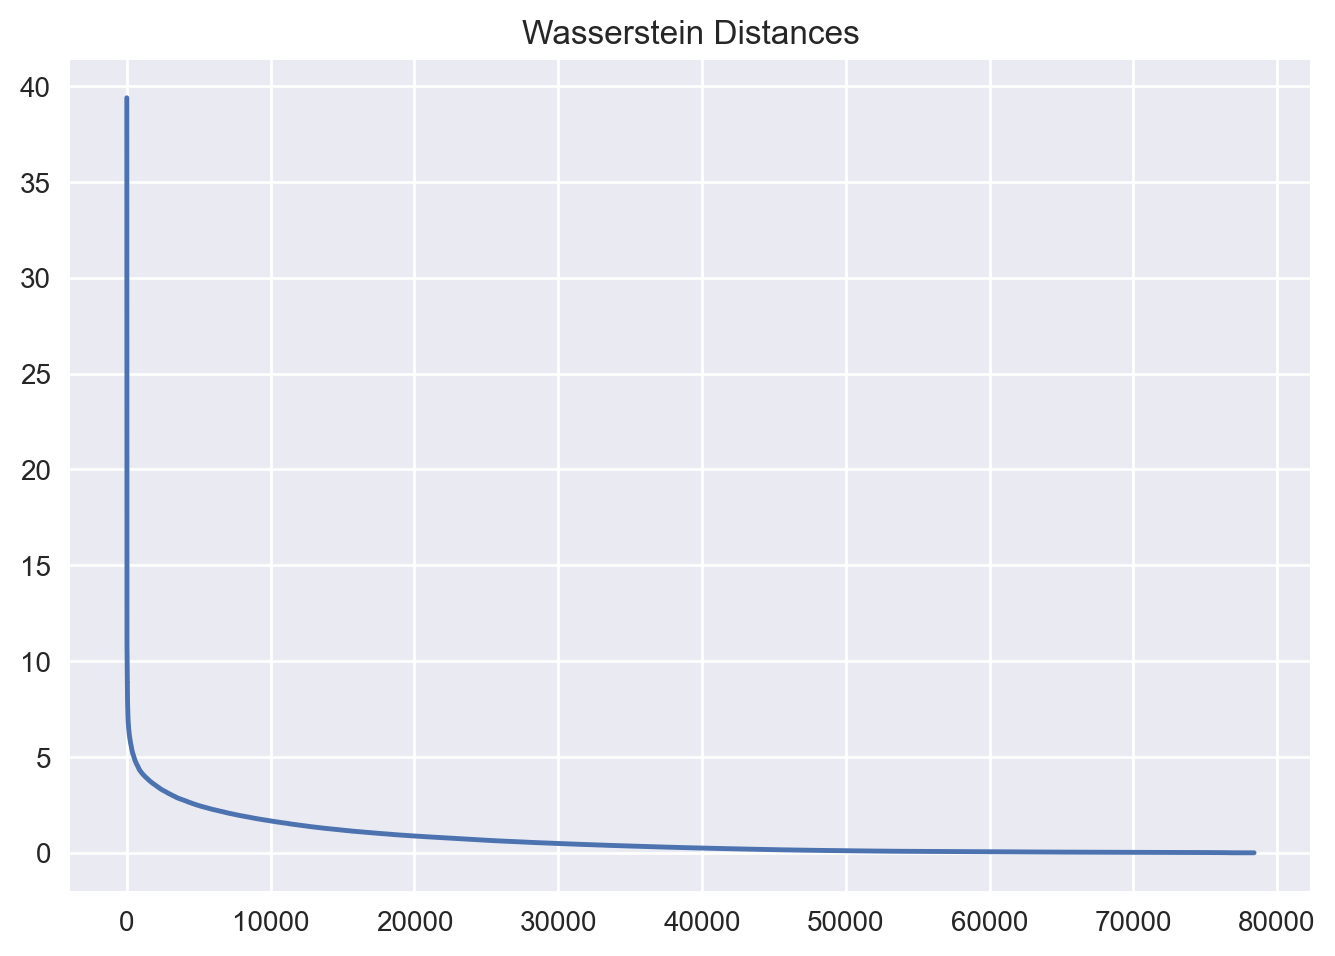

In [7]:
plt.plot(sorted(ws_distances)[::-1])
plt.title('Wasserstein Distances')
plt.show()

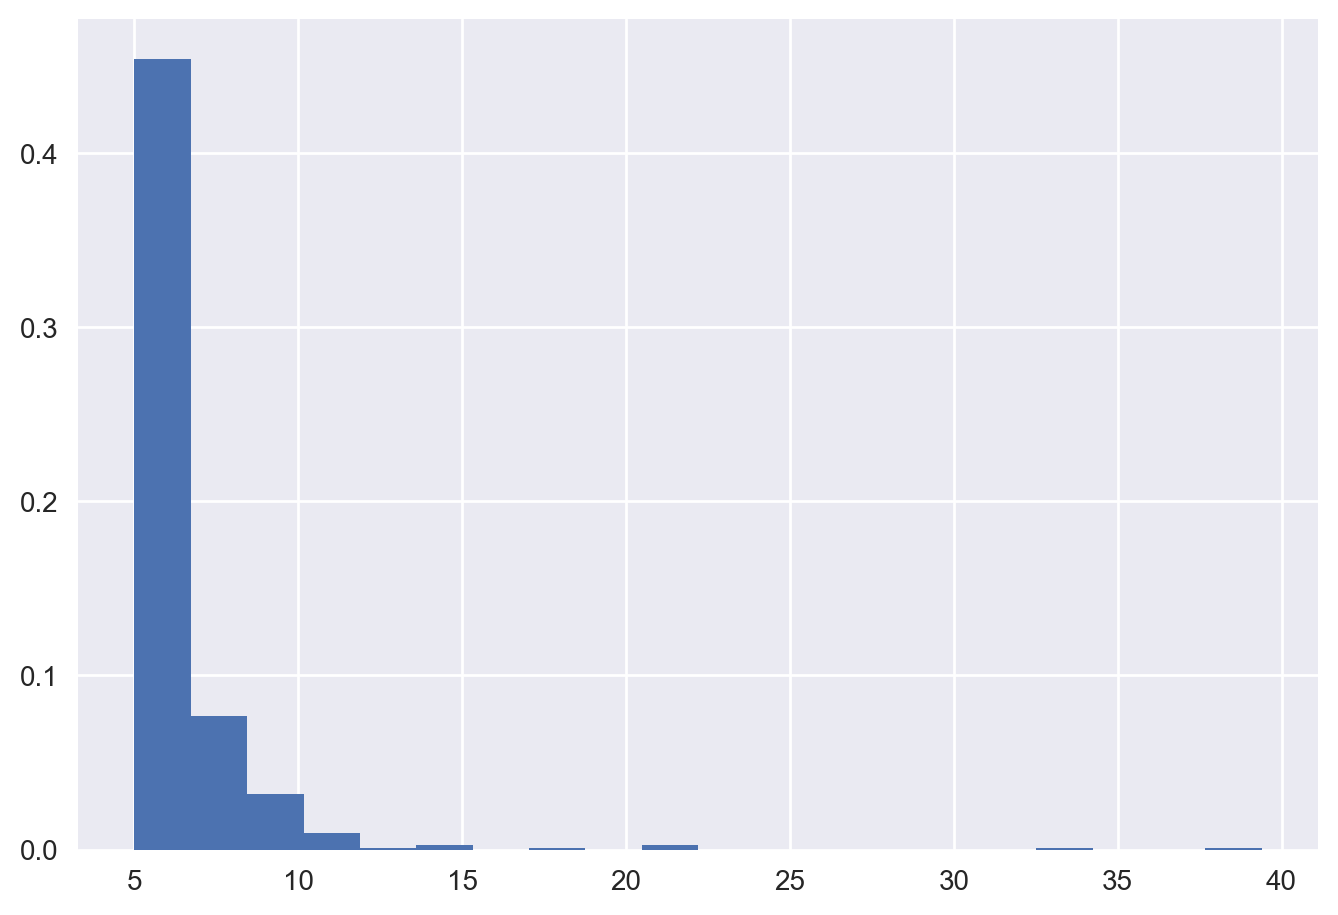

In [13]:
mask = ws_distances > 5
plt.hist(ws_distances[mask], bins=20, density=True)
plt.show()

In [9]:
ws_distances.argmax()

76539

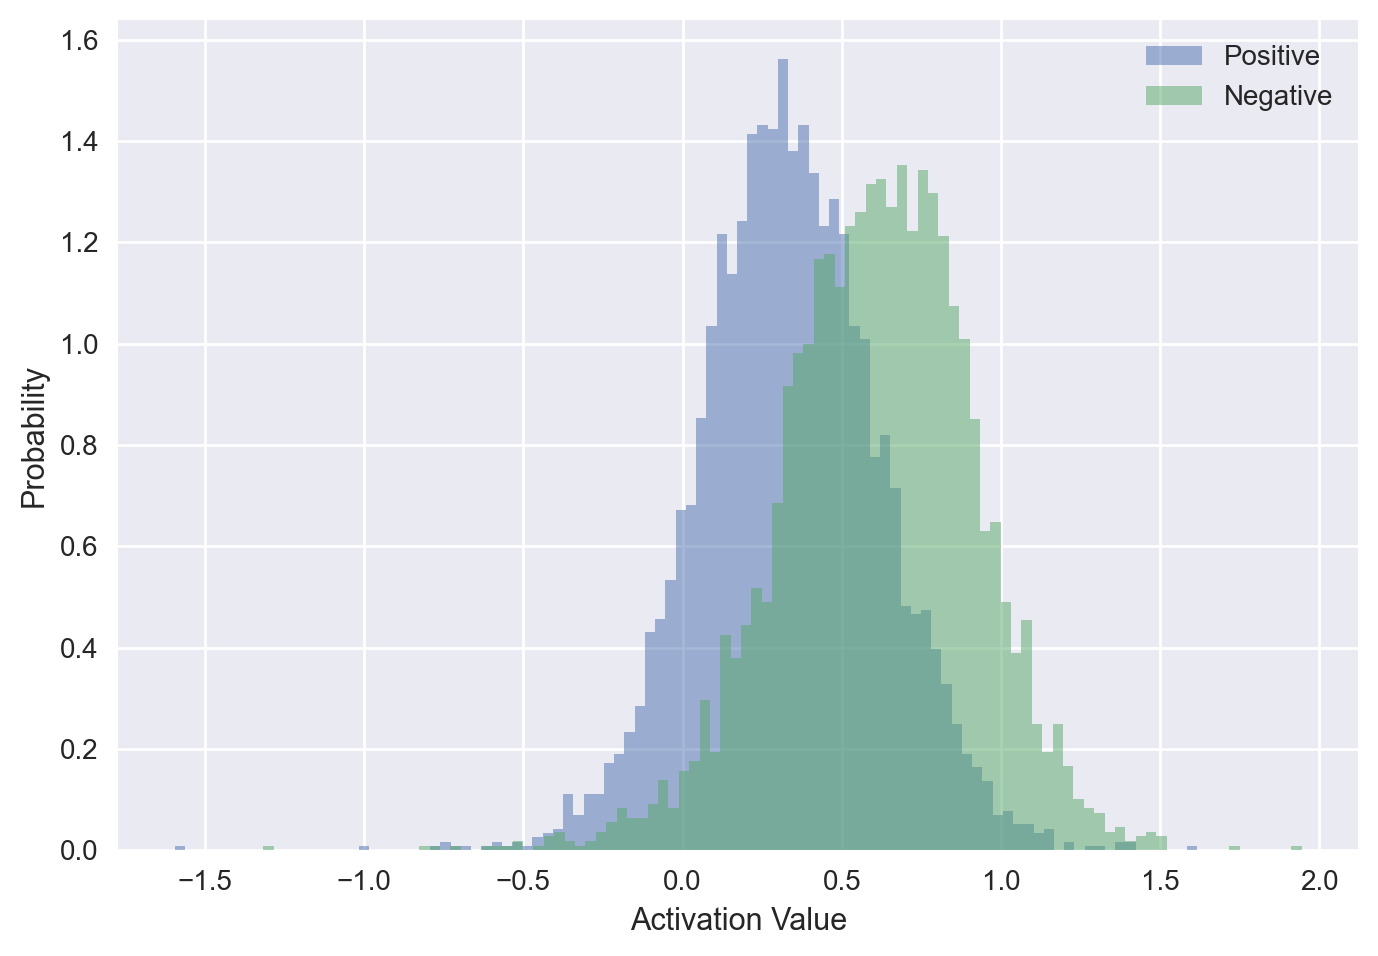

In [36]:
plt.hist(danger_samples[78206], bins=100, alpha=0.5, density=True, label="Positive")
plt.hist(safe_samples[78206], bins=100, alpha=0.5, density=True, label="Negative")
plt.legend()
plt.xlabel('Activation Value')
plt.ylabel('Probability')
plt.show()

In [11]:
ws_distances_reshaped = ws_distances.reshape(-1, 1600)

In [12]:
np.unravel_index(76539, ws_distances_reshaped.shape)

(47, 1339)

In [13]:
neurons_per_layer = {}
for arg in ws_distances.argsort()[::-1][:100]:
    layer, neuron = np.unravel_index(arg, ws_distances_reshaped.shape)
    layer, neuron = int(layer), int(neuron)
    if layer in neurons_per_layer:
        neurons_per_layer[layer].append(neuron)
    else:
        neurons_per_layer[layer] = [neuron]

In [14]:
with open('neurons_per_layer.json', 'w') as file:
    json.dump(neurons_per_layer, file)

In [16]:
len(sum([v for k, v in neurons_per_layer.items()],[]))

100

In [17]:
ws_distances.shape

(78400,)

In [22]:
ws_distances_reshaped.shape

(49, 1600)

In [20]:
rand_neurons = np.random.randint(low=0, high=ws_distances.shape[0], size=100)
rand_neurons_per_layer = {}
for neuron in rand_neurons:
    layer, neuron = np.unravel_index(neuron, ws_distances_reshaped.shape)
    layer, neuron = int(layer), int(neuron)
    if layer in rand_neurons_per_layer:
        rand_neurons_per_layer[layer].append(neuron)
    else:
        rand_neurons_per_layer[layer] = [neuron]

In [23]:
X_vals.shape

(6920, 49, 1600)